This notebook will determine the size of the > 255K "blobs" of interest in the satellite imagery data below.

First, open the dataset which is on DAP/RAMADDA server at Unidata.

We are using a library called **xray** to open and retrieve data out of the dataset.

In [76]:
import xray
ds = xray.open_dataset('https://motherlode.ucar.edu/repository/opendap/8ad58eff-68ac-45d0-b805-bf72958bfe3f/entry.das', decode_times=False)
ds


<xray.Dataset>
Dimensions:     (auditCount: 2, time: 1, xc: 728, yc: 306)
Coordinates:
  * time        (time) int32 1429772880
    lat         (yc, xc) float32 ...
    lon         (yc, xc) float32 ...
  * auditCount  (auditCount) int64 0 1
  * xc          (xc) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * yc          (yc) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    version     int32 ...
    sensorID    int32 ...
    imageDate   int32 ...
    imageTime   int32 ...
    startLine   int32 ...
    startElem   int32 ...
    dataWidth   int32 ...
    lineRes     int32 ...
    elemRes     int32 ...
    prefixSize  int32 ...
    crDate      int32 ...
    crTime      int32 ...
    bands       int32 ...
    auditTrail  (auditCount) |S64 ...
    data        (time, yc, xc) float32 ...
Attributes:
    Conventions: CF-1.4
    Source: McIDAS Area File
    Satellite_Sensor: G-13 IMG    
    DODS.strlen: 80
    DODS.dimName: auditSize

Grab the **temperature**, **latitude**, and **longitude** data.

In [77]:
temperature = ds['data'].values[0]
lat = ds['lat'].values
lon = ds['lon'].values

Sanity check the temperature values which are in Kelvin.

In [78]:
temperature

array([[ 282.487854  ,  282.487854  ,  282.487854  , ...,  282.75640869,
         282.21856689,  283.02426147],
       [ 282.353302  ,  282.353302  ,  282.353302  , ...,  281.94854736,
         281.81323242,  282.21856689],
       [ 283.42468262,  283.69070435,  283.02426147, ...,  282.08364868,
         281.94854736,  282.08364868],
       ..., 
       [ 248.34147644,  253.22015381,  256.00119019, ...,  225.70620728,
         230.67391968,  235.25868225],
       [ 252.84150696,  253.97175598,  256.90625   , ...,  225.41722107,
         229.87477112,  235.01274109],
       [ 262.29742432,  264.94619751,  265.43362427, ...,  224.83476257,
         227.68904114,  231.72305298]], dtype=float32)

Next, plot these data to get our bearings. We first need to figure out the latitude and longitude extents of our plot.

In [79]:
top = lat[0][0]
bottom = lat[-1][-1]
left = lon[0][0]
right = lon[-1][-1]
extents = (left, right, bottom, top)
extents

(-77.996666, -55.415195, -46.269196, -29.850424)

Let's start putting together our first plot with the help of **matplotlib** and **Cartopy** geoplotting library.

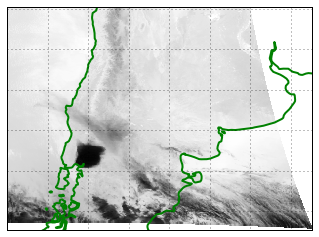

In [80]:
%matplotlib inline

# importing cartopy and matplotlib stuff
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

# PlatteCarre projection
pcprj = ccrs.PlateCarree()
ax = plt.axes(projection=pcprj)
extents = (left, right, bottom, top)
ax.pcolormesh(lon, lat, temperature, cmap=cm.gray, transform=pcprj)
ax.coastlines(resolution='50m', color='green', linewidth=2)
ax.set_extent(extents, ccrs.Geodetic())
ax.gridlines()

plt.show()

If we are going calculating the **areas** of regions of interest  in a plot we need to make use of an equal area projection, in this case the **Albers** equal area projection.

In [81]:
central_lon = (right-left)/2 + left
central_lat = (top-bottom)/2 + bottom
aeprj = ccrs.AlbersEqualArea(central_longitude=central_lon,
                             central_latitude=central_lat,
                             standard_parallels=(-20, -50))

Now that we have defined our AE projection, we can plot the data with the new projection.

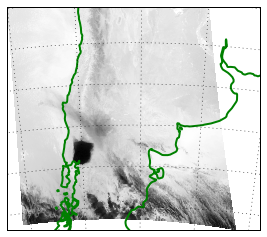

In [82]:
  ax = plt.axes(projection=aeprj)
  extents = (left, right, bottom, top)
  ax.pcolormesh(lon, lat, temperature, cmap=cm.gray, transform=pcprj)
  ax.coastlines(resolution='50m', color='green', linewidth=2)
  ax.set_extent(extents, ccrs.Geodetic())
  ax.gridlines()

  plt.show()

We are specifically interested in regions that are > 255K so let's mask out those data.

In [83]:
import numpy.ma as ma

# There may be a much slicker/better more Pythonic, numpy oriented way to do
# this.
mask255 = ma.masked_where(temperature > 255,temperature).mask
ones = ma.ones(temperature.shape).data
t255 = ma.masked_values(ones,mask255).fill_value

Let's plot these > 255K data.

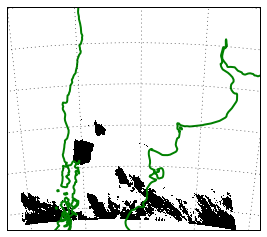

In [84]:
ax = plt.axes(projection=aeprj)
extents = (left, right, bottom, top)
ax.pcolormesh(lon, lat, t255, cmap=cm.gray, transform=pcprj)
ax.coastlines(resolution='50m', color='green', linewidth=2)
ax.set_extent(extents, ccrs.Geodetic())
ax.gridlines()

plt.show()

Now let's zoom into to our region of interest.

In [85]:
ileft = -74
iright = -69
ibottom = -42
itop = -38
img_extents = (ileft, iright, ibottom, itop)

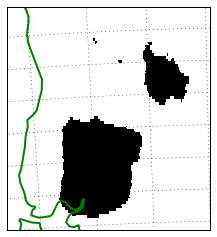

In [86]:
ax = plt.axes(projection=aeprj)
extents = (left, right, bottom, top)
ax.pcolormesh(lon, lat, t255, cmap=cm.gray, transform=pcprj)
ax.coastlines(resolution='50m', color='green', linewidth=2)
ax.set_extent(img_extents, ccrs.Geodetic())
ax.gridlines()

plt.show()

If we are going to calculate the area of the > 255K "blobs", we first need to determine the area of this zoomed in region. We can do this with the help of  Cartopy and the fact that we are using an equal area projection.

In [87]:
x0, y0 = aeprj.transform_point(ileft,ibottom, pcprj)
x1, y1 = aeprj.transform_point(iright,itop, pcprj)
# units are in meters so let's divide by 10^6
area = ((y1-y0) * (x1-x0))/1000000
area

186877.89828483455

The region we are looking at is about 186,878KM^2. Next we need to determine the areas of the blobs. For this part, we will use some image manipulation trickery.

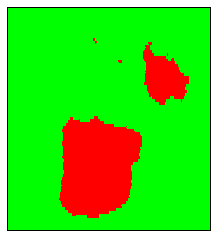

In [88]:
# Easy to work with color map. This will make more sense below when we are
# couting colored pixels.
cmap = mpl.colors.ListedColormap([[1., 0., 0],[0., 1., 0]])
ax = plt.axes(projection=aeprj)
ax.pcolormesh(lon, lat, t255, cmap=cmap, transform=pcprj)
ax.set_extent(img_extents, ccrs.Geodetic())
plt.savefig("volcano.png", bbox_inches='tight', pad_inches=0)
plt.show()

At this point, it is just a matter just a matter counting the red pixel versus green pixels, obtaining a ratio, and multiplying by th area.

In [89]:
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread('volcano.png')[:, :, :3]
img.shape
img2 = img.reshape(img.shape[0]*img.shape[1], 3)
green = len([i for i in img2
             if np.array_equal(i, np.array([0.,  1., 0.], dtype='f32'))])
red = len([i for i in img2
           if np.array_equal(i, np.array([1.,  0., 0.], dtype='f32'))])
green, red

/home/python/anaconda/envs/unidata/lib/python3.4/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Specified size is invalid for this data type.
Size will be ignored in NumPy 1.7 but may throw an exception in future versions.
/home/python/anaconda/envs/unidata/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: Specified size is invalid for this data type.
Size will be ignored in NumPy 1.7 but may throw an exception in future versions.


(36707, 8137)

In [90]:
blob = red/(red + green) * area
blob

33909.22884541296

The size of the blobs are about 33,909 KM^2.